In [1]:
from glob import glob
import pandas as pd
import os
from tqdm import tqdm as tqdm 
from IPython.display import Image
from pathlib import Path

In [65]:
subject_mapping = {"m00183": "sub_1",
                   "m00184": "sub_2",
                   "m00185": "sub_3",
                   "m00187": "sub_4",
                   "m00188": "sub_5",
                   "m00191": "sub_6",
                   "m00192": "sub_7",
                   "m00193": "sub_8",
                   "m00194": "sub_9",
                   "m00195": "sub_10",
                  }

In [72]:
from tqdm import tqdm
import h5py
import math
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import json
import scipy.stats
import time
from types import SimpleNamespace
import random
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

save_dir = 'brain_plotting/'
base_path = 'brain_plotting/'
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'
correlations_file = 'lag_correlation.json'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [subject_mapping[t[0]] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# # Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))

# scaled_coords_df[]
scaled_coords_df["ID"] = scaled_coords_df.Electrode + "-" + scaled_coords_df.Subject

In [224]:
import seaborn as sns
def plot_electrodes(plot_df, ax=None, hemisphere="left", title=None):
    plot_df = plot_df.dropna() #TODO NOTE
    plot_df.sort_values(by='avg_test', ascending=False)

    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==1]
    elif hemisphere=="right":
        ax.imshow(right_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==0]


    ax.axis('off')
    assert hemisphere in ["left", "right"]


    plot_title = f'{hemisphere} hemisphere'

    if title:
        plot_title += f' {title}'

    all_x = plot_df['X']
    all_y = plot_df['Y']
    color = plot_df['avg_test']

    sc = ax.scatter(all_x, all_y,
                s=50,
                linewidths=1,
                c=color,
                edgecolors="black",
                clip_on=False,
                cmap="viridis",
#                 vmin=0.48,
#                 vmax=0.75
                   )
    return sc

In [146]:
results_root = "/storage/czw/linear_voltage_single_electrode_SS_SM_prototype/linear_voltage_single_electrode"


In [147]:
# results

In [148]:
def get_test_results(results, eval_name):
    eval_results = results["evaluation_results"]
    assert len(eval_results.keys()) == 1
    records = []
    for subject_trial in eval_results:
        subject = subject_trial.split("_")[0][len("btbank"):]
        trial = subject_trial.split("_")[1]
        subject_trial_results = eval_results[subject_trial]['electrode']
        for electrode in subject_trial_results:
            electrode_results = subject_trial_results[electrode]
            time_bin_results = electrode_results["time_bins"]
            for time_bin in time_bin_results:
                time_bin_start = time_bin['time_bin_start']
                fold_results = time_bin['folds']
                avg_test = np.mean([f['test_roc_auc'] for f in fold_results])
                records.append({
                    "subject": subject,
                    "trial": trial,
                    "ID": f'{electrode}-sub_{subject}',
                    "electrode": electrode,
                    "avg_test": avg_test,
                    "time_bin": time_bin_start,
                    "task": eval_name
                })
        return records

In [149]:
all_records = []
all_results_paths = glob(os.path.join(results_root, "*"))
for path in tqdm(all_results_paths):
    name = Path(path).stem
    sub_id = name.split("_")[1][len("btbank"):]
    trial_id = name.split("_")[2]
    eval_name = "_".join(name.split("_")[3:])
    with open(path, "r") as f:
        results = json.load(f)
        test_results = get_test_results(results, eval_name)
    all_records += test_results
results_df = pd.DataFrame.from_records(all_records)

100%|██████████████████████████████████████████████████████████████████████████████████| 228/228 [00:47<00:00,  4.79it/s]


In [150]:
# all_results_paths

In [191]:
np.percentile(results_df["avg_test"],99)

0.556821371925552

In [152]:
spatial_avg_results_df = results_df.groupby(['task','ID']).max(['avg_test'])

In [164]:
tasks

['global_flow',
 'onset',
 'word_gap',
 'gpt2_surprisal',
 'word_index',
 'word_head_pos',
 'local_flow',
 'face_num',
 'volume',
 'local_flow_angle',
 'speaker',
 'pitch',
 'speech',
 'frame_brightness',
 'word_part_speech',
 'global_flow_angle',
 'delta_pitch',
 'word_length',
 'delta_volume']

In [163]:
tasks = list(set(results_df.task))

/storage/czw/anaconda3/envs/sss/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


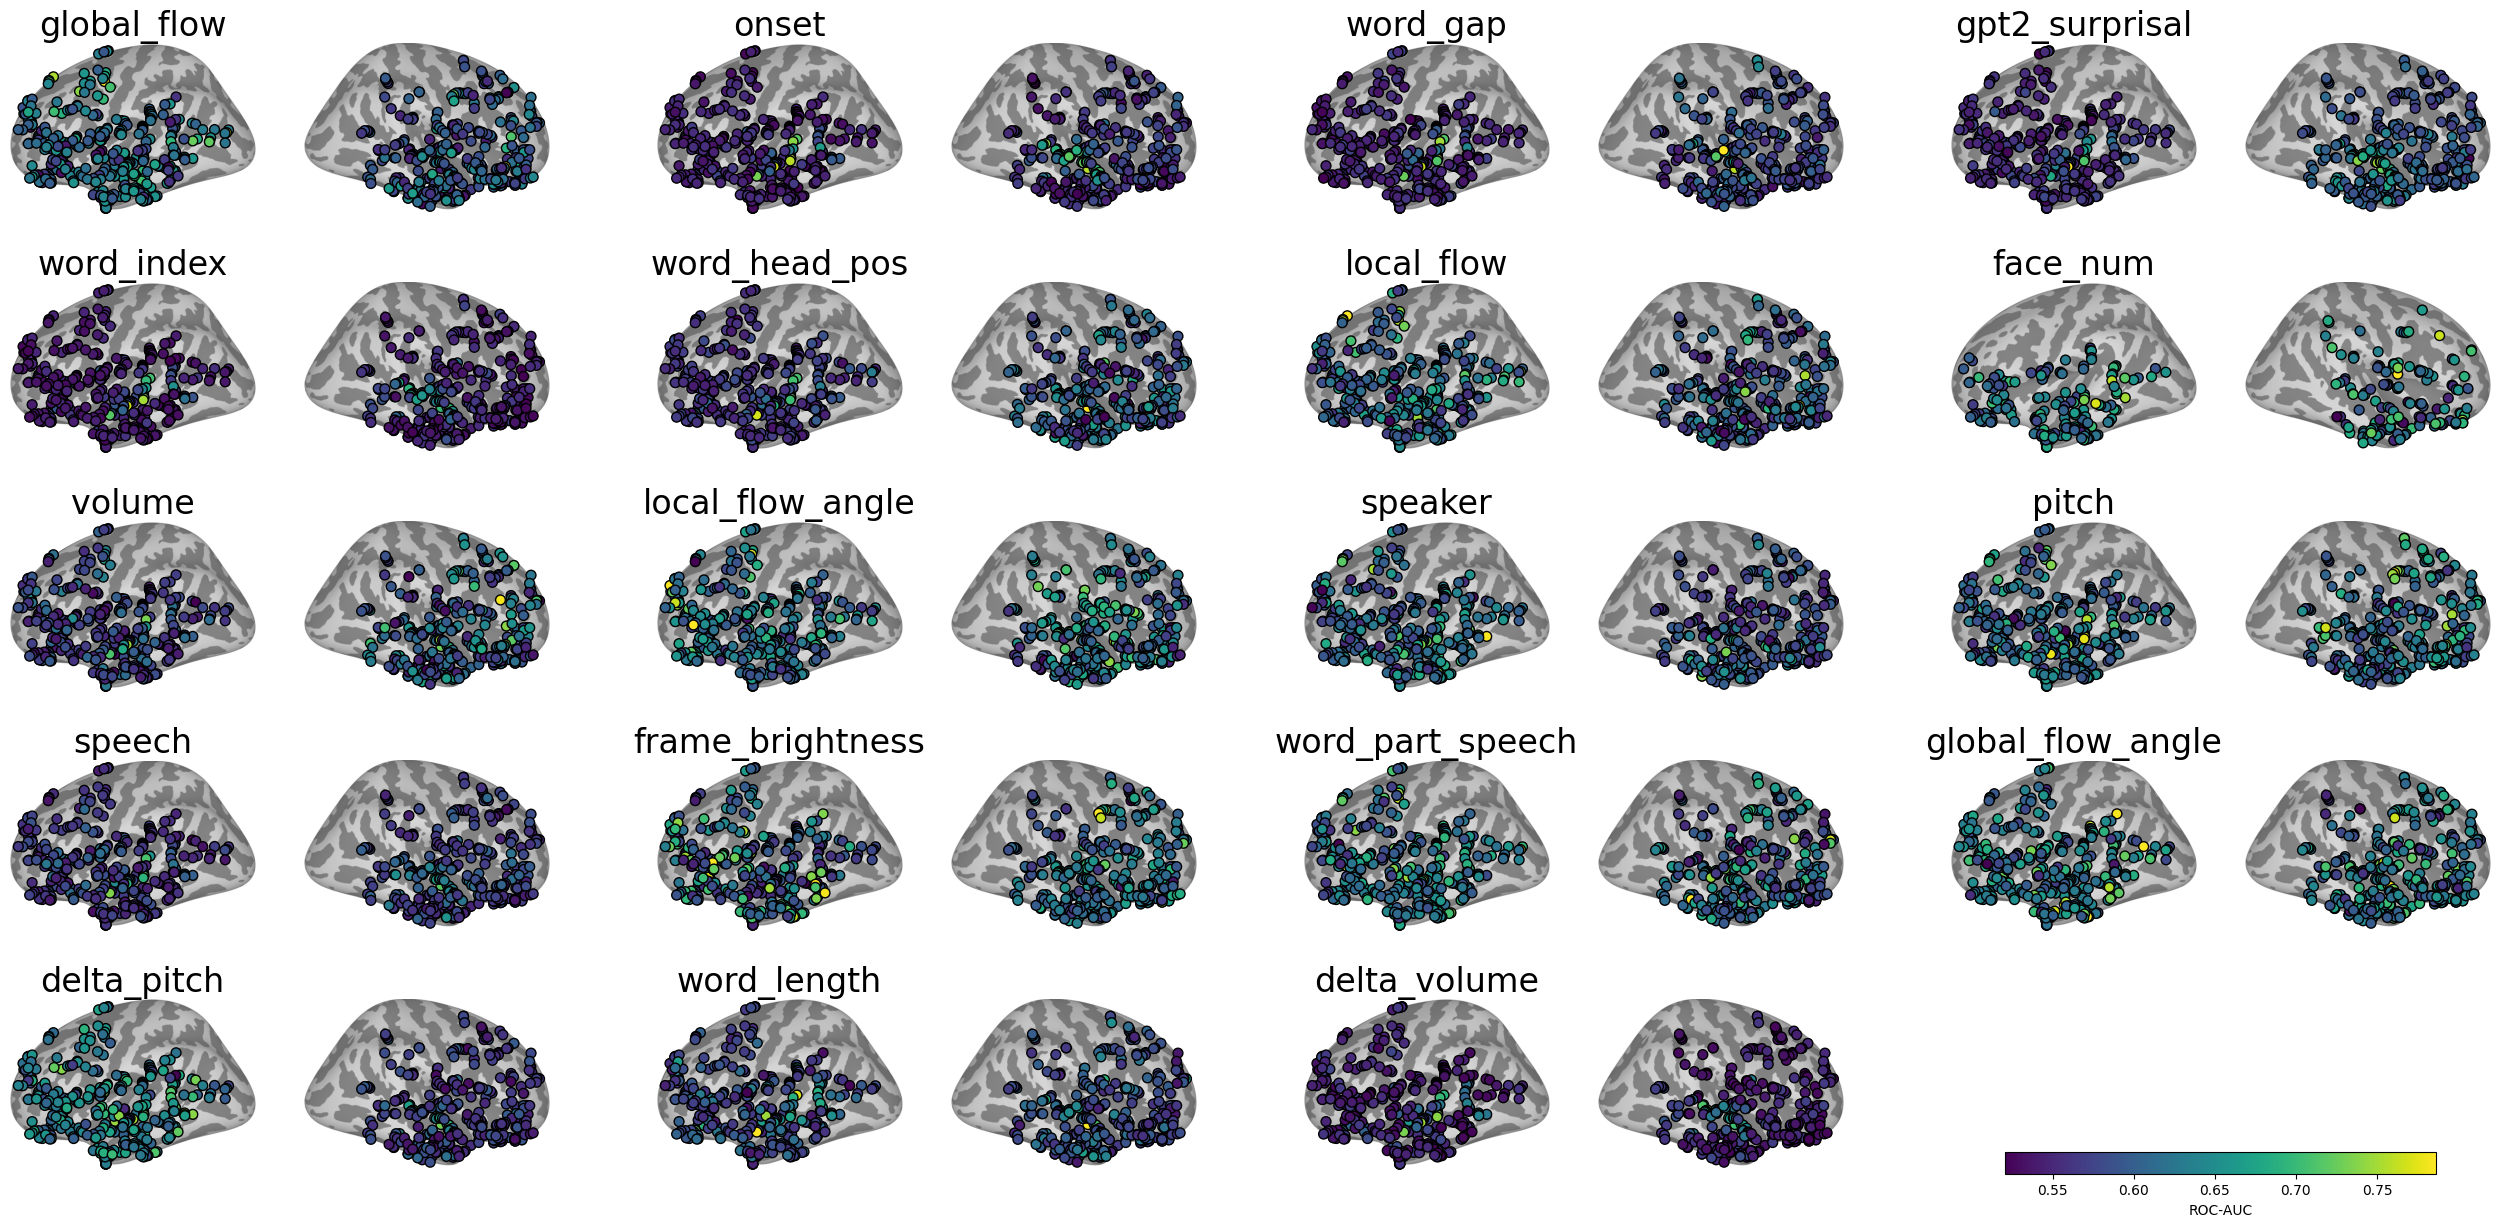

In [226]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(32, 15))

outer = gridspec.GridSpec(5, 4, wspace=0.2, hspace=0.2)

# Loop through each subplot and add a simple plot or title
for i in range(5):
    for j in range(4):
        # Index in outer grid
        outer_idx = i * 4 + j

        if i*4+j >= 19:
            ax = fig.add_subplot(outer[19])
            cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', shrink=0.8)
            cbar.set_label("ROC-AUC")
            ax.set_axis_off()
            continue
            
        # Define inner 2x1 grid within this cell
        inner = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec=outer[outer_idx], hspace=0.1
        )
            
        for k in range(2):
            ax = fig.add_subplot(inner[k])
#             print(i*4+j)
            task = tasks[i*4+j]
            task_df = spatial_avg_results_df.loc[task]
            merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")
            hem = ["left","right"][k]
            sc = plot_electrodes(merged_df, hemisphere=hem, ax=ax, title=task)
#             ax.set_title(task)
            
            if k == 0:
                ax.set_title(task, fontsize=24)
                
plt.tight_layout()

In [206]:
len(tasks)

19

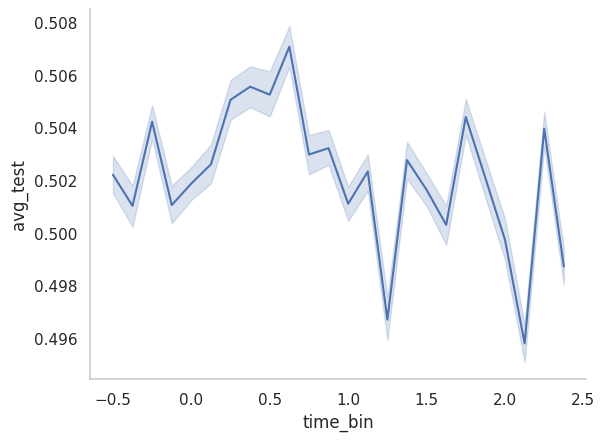

In [233]:
import seaborn as sns



/storage/czw/anaconda3/envs/sss/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


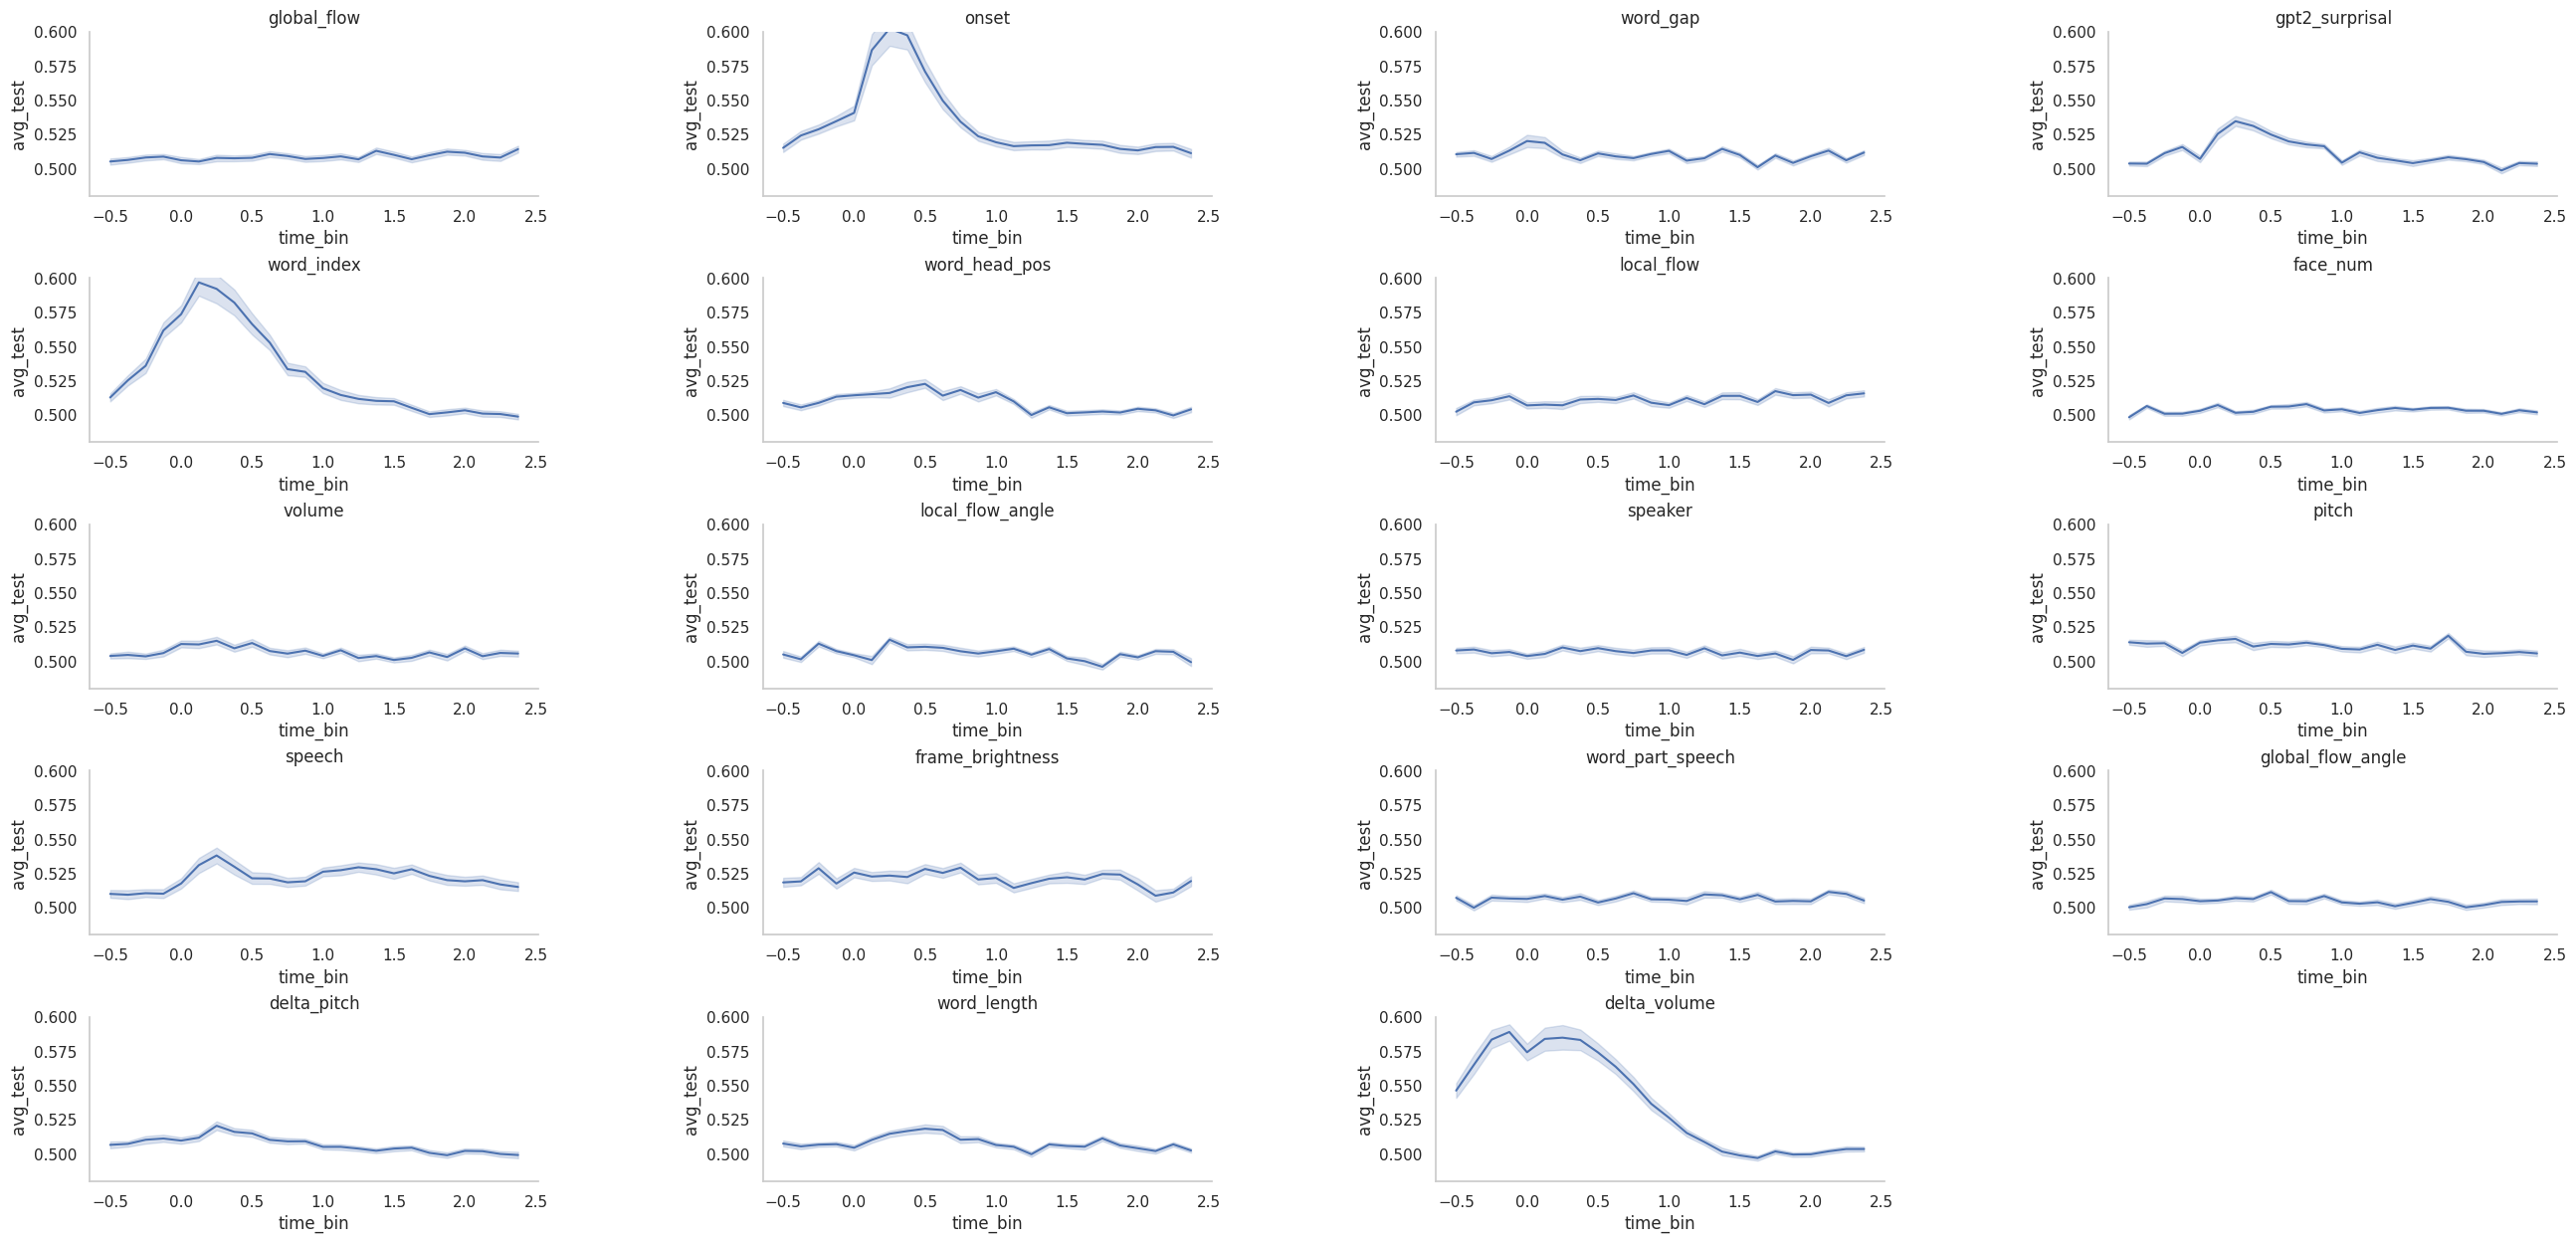

In [274]:
fig = plt.figure(figsize=(32, 15))

outer = gridspec.GridSpec(5, 4, wspace=0.5, hspace=0.5)

# Loop through each subplot and add a simple plot or title
for i in range(5):
    for j in range(4):
        # Index in outer grid
        outer_idx = i * 4 + j

        if i*4+j >= 19:
            continue

        ax = fig.add_subplot(outer[outer_idx])
        task = tasks[i*4+j]

        task_df = results_df[results_df.task==task].groupby("ID").mean()
        good_elecs = task_df[task_df.avg_test>0.5].index   
        
        good_elecs = results_df[results_df.task==task].groupby("ID").mean().sort_values(by="avg_test")[-100:].index        
        time_df = results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]
#         time_df = results_df[(results_df.task==task)]

        # sns.set(style="whitegrid")

        # Create lineplot
        sns.lineplot(data=time_df, x="time_bin", y="avg_test")
        # plt.axis("off")  # disables the entire axis (spines, ticks, labels, etc.)
        plt.grid(False)  # ensures grid lines are also off
        ax.set_title(task)
        sns.despine() 
        plt.ylim(0.48, 0.60)
plt.tight_layout()

In [275]:
merged_df


,Unnamed: 0,ID,Z,X,Y,Hemisphere,Subject,Electrode,Region,avg_test,time_bin
0,0,T2aA12-sub_1,36.764992,514.141351,547.159175,0,sub_1,T2aA12,G_temporal_middle,0.547928,2.375
1,1,T2aA11-sub_1,36.236805,522.194018,546.942302,0,sub_1,T2aA11,G_temporal_middle,0.551926,2.375
2,2,T2aA10-sub_1,35.359528,532.632580,546.963954,0,sub_1,T2aA10,S_temporal_sup,0.538053,2.375
3,3,T2aA9-sub_1,34.834171,539.301227,538.800944,0,sub_1,T2aA9,S_temporal_sup,0.536552,2.375
4,4,T2aA8-sub_1,35.145645,536.670993,538.386399,0,sub_1,T2aA8,S_temporal_sup,0.534899,2.375
...,...,...,...,...,...,...,...,...,...,...,...
1655,1655,RF1bCb5-sub_7,30.837800,678.831303,141.539945,0,sub_7,RF1bCb5,G_and_S_cingul-Mid-Ant,0.534335,2.375
1656,1656,RF1bCb4-sub_7,33.082900,626.052506,194.294490,0,sub_7,RF1bCb4,G_and_S_cingul-Mid-Ant,0.552961,2.375
1657,1657,RF1bCb3-sub_7,34.910400,629.535438,223.375651,0,sub_7,RF1bCb3,G_and_S_cingul-Mid-Ant,NaN,NaN
1658,1658,RF1bCb2-sub_7,35.243900,627.667181,227.268739,0,sub_7,RF1bCb2,G_and_S_cingul-Mid-Ant,NaN,NaN


In [268]:
task_df[task_df.avg_test>0.5].index

Index(['F10Fa1-sub_10', 'F10Fa11-sub_10', 'F10Fa12-sub_10', 'F10Fa15-sub_10',
       'F10Fa16-sub_10', 'F10Fa3-sub_10', 'F10Fa8-sub_10', 'F2Ia1-sub_3',
       'F2Ia10-sub_3', 'F2Ia11-sub_3',
       ...
       'T3aHb9-sub_1', 'T3bOT10-sub_1', 'T3bOT12-sub_1', 'T3bOT2-sub_1',
       'T3bOT3-sub_1', 'T3bOT4-sub_1', 'T3bOT5-sub_1', 'T3bOT6-sub_1',
       'T3bOT8-sub_1', 'T3bOT9-sub_1'],
      dtype='object', name='ID', length=714)